# Assignment 6 - GVFs and Successor Representation

## Track 2, Part A.

In [1]:
import grid_task
import numpy as np
import animations
import time
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Circle, PathPatch
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from sklearn.preprocessing import scale, normalize

### Environment inspired from Dayan’s Successor Representation paper:
http://www.gatsby.ucl.ac.uk/~dayan/papers/d93b.pdf
### Built in pycolab.

In [2]:
# Map observation to set of coordinates
def obs_to_state(obs):
  arr = np.array(obs.layers['P'], dtype=np.float)
  agent_position = np.argwhere(arr)[0]
  a,b = agent_position[0], agent_position[1]
  return a,b

In [3]:
grid_task.discount_factor = 0.90
grid_task.transition_penalty = 0.0
grid_task.goal_reward = 1.0

print('Environment:')
game_art = grid_task.GAME_ART
print('-',''.join([str(i) for i in range(len(game_art[0]))]))
for i,line in enumerate(game_art):
    print(i,line)

game = grid_task.make_game()
obs, reward, gamma = game.its_showtime()
print('\nAgent starts at: %s\n%s'%(obs_to_state(obs), np.array(obs.layers['P'], dtype=np.float)))
print('\nEnvironment dimensions (including borders):', np.array(obs.layers['P'], dtype=np.float).shape)

X_dim = np.array(obs.layers['P'], dtype=np.float).shape[0]
Y_dim = np.array(obs.layers['P'], dtype=np.float).shape[1]

n_states = X_dim*Y_dim
        
states = []
for i in range(X_dim):
    for j in range(Y_dim):
        states.append((i,j))

state_to_index = {}
index_to_state = {}
for i, state in enumerate(states):
    state_to_index[state] = i
    index_to_state[i] = state

print('\nStates (%s -- some inaccessible):\n'%len(states),states)

Environment:
- 0123456789101112
0 #############
1 #           #
2 #     ###   #
3 #     #     #
4 #     #P    #
5 #     #     #
6 #     ###   #
7 #           #
8 #############

Agent starts at: (4, 7)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Environment dimensions (including borders): (9, 13)

States (117 -- some inaccessible):
 [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (3, 0), 

Visualization of environment generated using "visualize_grid.py":


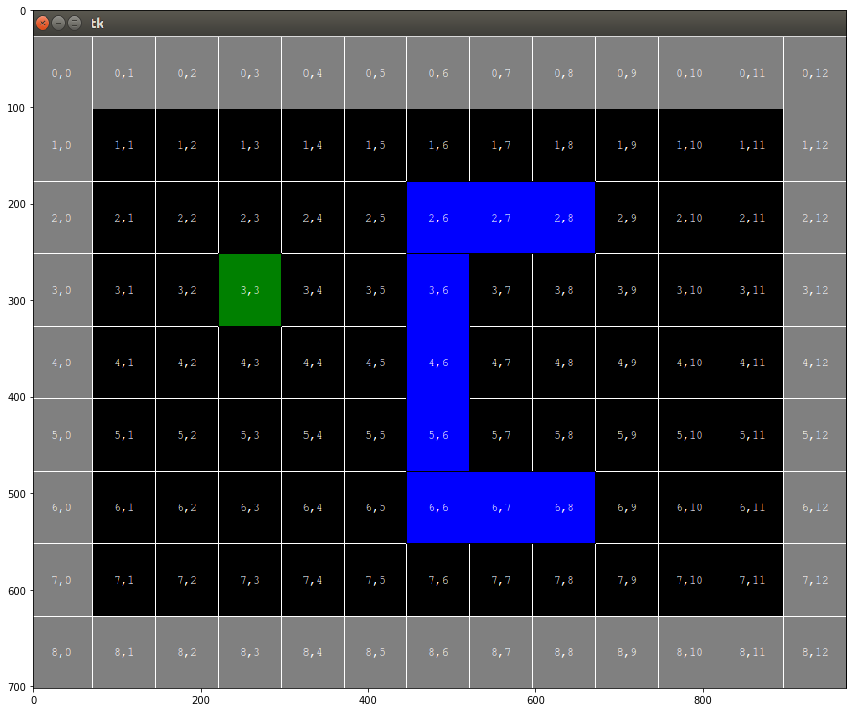

In [21]:
print('Visualization of environment generated using "visualize_grid.py":')
img=mpimg.imread('./images/envt.png')
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.imshow(img, aspect='auto')
plt.tight_layout()
plt.show()

### Computing transition probability matrix, $\large P_{\pi=\textit{random}}$

In [5]:
P = {}
for s in states: 
    P[s] = {}
    for s_ in states:
        diff = (np.array(s) - np.array(s_))**2
        if diff[0] + diff[1] == 0: # self
            P[s][s_] = 0
        elif diff[0] + diff[1] == 1: # one-away
            P[s][s_] = 0.25
        else:
            P[s][s_] = 0 # more than one-away

# Inaccessible states
for s in P:
    if s[0] == 0 or s[0] == 8 or s[1] == 0 or s[1] == 12:
        for s_ in P[s]:
            P[s][s_] = 0.0
            
# Edge cases
for i in range(2,11):
    s = (1,i)
    s_ = (0,i)
    P[s][s_] = 0.0
    P[s][s] = 0.25
    
for i in range(2,11):
    s = (7,i)
    s_ = (8,i)
    P[s][s_] = 0.0
    P[s][s] = 0.25

for i in range(2,7):
    s = (i,1)
    s_ = (i,0)
    P[s][s_] = 0.0
    P[s][s] = 0.25
    
for i in range(2,7):
    s = (i,11)
    s_ = (i,12)
    P[s][s_] = 0.0
    P[s][s] = 0.25

# Top left corner
s = (1,1)
P[s][s] = 0.5
for s_ in [(0,1),(1,0)]:
    P[s][s_] = 0.0

# Top right corner
s = (1,11)
P[s][s] = 0.5
for s_ in [(0,11),(1,12)]:
    P[s][s_] = 0.0

# Bottom left corner
s = (7,1)
P[s][s] = 0.5
for s_ in [(8,1),(7,0)]:
    P[s][s_] = 0.0

# Bottom right corner
s = (7,11)
P[s][s] = 0.5
for s_ in [(7,12),(8,11)]:
    P[s][s_] = 0.0
    
# Above wall
for i in range(6,9):
    s = (1,i)
    s_ = (2,i)
    P[s][s_] = 0.0
    P[s][s] = 0.5

# Below wall
for i in range(6,9):
    s = (7,i)
    s_ = (6,i)
    P[s][s_] = 0.0
    P[s][s] += 0.25
    
# Left of wall
for i in range(2,7):
    s = (i,5)
    s_ = (i,6)
    P[s][s_] = 0.0
    P[s][s] += 0.25
    
# Top corner behind wall
s = (3,7)
P[s][s] += 0.5
for s_ in [(2,7),(3,6)]:
    P[s][s_] = 0.0

# Bottom corner behind wall
s = (5,7)
P[s][s] += 0.5
for s_ in [(2,7),(3,6)]:
    P[s][s_] = 0.0

# Behind wall: (4,7)
s = (4,7)
s_ = (4,6)
P[s][s_] = 0.0
P[s][s] += 0.25

# Behind wall: (3,8)
s = (3,8)
s_ = (2,8)
P[s][s_] = 0.0
P[s][s] += 0.25

# Behind wall: (5,8)
s = (5,8)
s_ = (6,8)
P[s][s_] = 0.0
P[s][s] += 0.25

# The wall itself - top
for i in (6,9):
    s = (2,i)
    for s_ in states:
        P[s][s_] = 0.0
        
# The wall itself - bottom
for i in (6,9):
    s = (6,i)
    for s_ in states:
        P[s][s_] = 0.0

# The wall itself - vertical
for i in (2,7):
    s = (i,6)
    for s_ in states:
        P[s][s_] = 0.0
        
# Goal 
#s = (3,3)
#for s_ in states:
#    P[s][s_] = 0.0

In [6]:
# Transform dictionary to a matrix
P_matrix = np.zeros((n_states, n_states))
for s in states:
    i = state_to_index[s]
    for s_ in states:
        j = state_to_index[s_]
        P_matrix[i,j] = P[s][s_]

### Define reward function, $\large r_{\pi}(s)$
Immediate reward is zero for any transition, except for transitions from the four boxes flanking the absorbing state (3,3) to the absorbing state. 

In [7]:
r = np.zeros(n_states)
for s in states:
    r[state_to_index[s]] = P[s][(3,3)] * 1.0

### Computing Successor Representation  Exactly
$$\LARGE\phi_{\pi}(s) = e^T_s(I - \gamma P_{\pi})^{-1}$$

In [8]:
def one_hot(state):
    e = np.zeros(n_states)
    i = state_to_index[state]
    e[i] = 1.0
    return e

In [9]:
# Calculate Phi exactly
Phi_exact = np.zeros((n_states,n_states))
gamma = 0.90
I = np.identity(P_matrix.shape[0])
for s in states:
    Phi_s = np.dot(one_hot(s),np.linalg.inv(I - (gamma * P_matrix)))
    Phi_exact[state_to_index[s]] = Phi_s

Exactly computed successor representation at position (3,7):


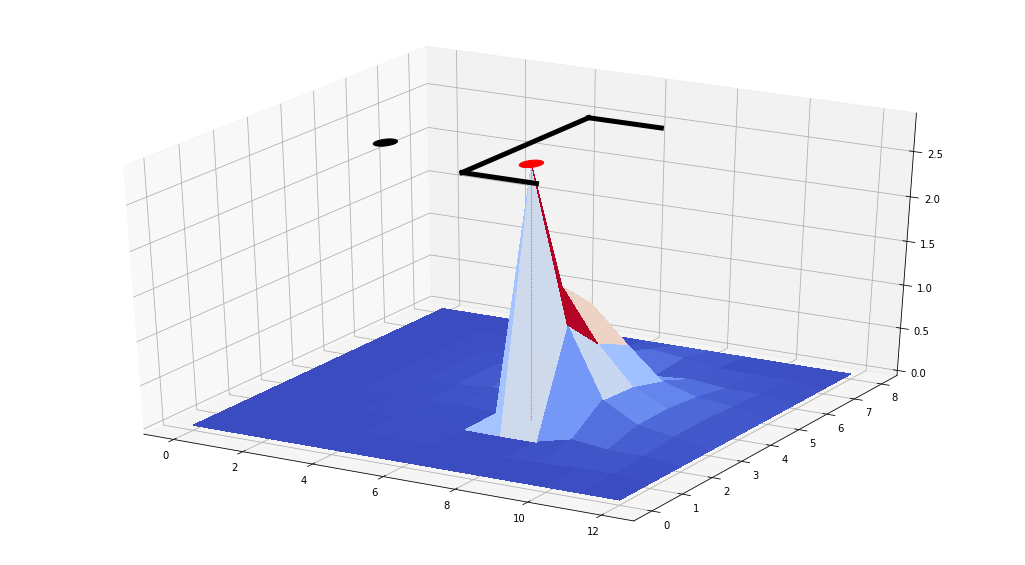

In [10]:
print('Exactly computed successor representation at position (3,7):')
plt.rcParams['figure.figsize'] = [18, 10]
s = (3,7)
Phi_s = Phi_exact[state_to_index[s]]
Z = np.zeros((X_dim, Y_dim))
for idx, z in enumerate(Phi_s):
    i,j = index_to_state[idx]
    Z[i,j] = z
    
X = np.array([i for i in range(Z.shape[0])])
Y = np.array([i for i in range(Z.shape[1])])
X, Y = np.meshgrid(Y, X)

fig=plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z,cmap = cm.coolwarm, linewidth=0, antialiased=False)
line = ax.plot([s[1],s[1]],[s[0],s[0]],[0,Z.max()],'k--',alpha=0.8, linewidth=0.5, color='red')

h=1.0*Z.max()
line = ax.plot([6,8],[2,2],[h,h], alpha=1, linewidth=5, color='black')
line = ax.plot([6,8],[6,6],[h,h], alpha=1, linewidth=5, color='black')
line = ax.plot([6,6],[2,6],[h,h], alpha=1, linewidth=5, color='black')
p = Circle((3, 3), 0.25, color='black')
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=h, zdir="z")

p = Circle((s[1], s[0]), 0.25, color='red')
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=h, zdir="z")

plt.show()

### Learning Successor Representation.

In [11]:
SR = {}
for s in states:
    SR[s] = {}
    for s_ in states:
        SR[s][s_] = 0.0

alpha=0.1
n_episodes = 10000
elapsed_episodes = 0
while True:
    steps = 0
    if elapsed_episodes > n_episodes:
        break
    while True:
        steps +=1
        
        a,b = obs_to_state(obs)
        # actions: (0,1,2,3)
        action = np.random.randint(4)
        
        obs, reward, gamma = game.play(action)
        a_,b_ = obs_to_state(obs)
        
        s = (a,b)
        s_ = (a_,b_)
                
        if gamma == 0: # Episode terminated
            elapsed_episodes += 1
            if elapsed_episodes%1000 == 0:
                print('episode # %s'%elapsed_episodes,25*'=', 'terminated in %s steps'%steps, 25*'=')
            game = grid_task.make_game()
            obs, reward, gamma = game.its_showtime()
            break
        
        for j in states:
            if s == j:
                SR[s][j] += alpha*(1 + gamma*SR[s_][j] - SR[s][j])
            else:
                SR[s][j] += alpha*(gamma*SR[s_][j] - SR[s][j])

episode # 1000 ========================= terminated in 508 steps =========================
episode # 2000 ========================= terminated in 348 steps =========================
episode # 3000 ========================= terminated in 660 steps =========================
episode # 4000 ========================= terminated in 48 steps =========================
episode # 5000 ========================= terminated in 233 steps =========================
episode # 6000 ========================= terminated in 965 steps =========================
episode # 7000 ========================= terminated in 2271 steps =========================
episode # 8000 ========================= terminated in 132 steps =========================
episode # 9000 ========================= terminated in 495 steps =========================
episode # 10000 ========================= terminated in 111 steps =========================


In [12]:
def predict_future_occupancy(s):
    M = np.zeros((X_dim, Y_dim))
    for i in range(X_dim):
        for j in range(Y_dim):
            M[i,j] = SR[s][(i,j)]
    return M

Learned Successor Representation at state (3,7):


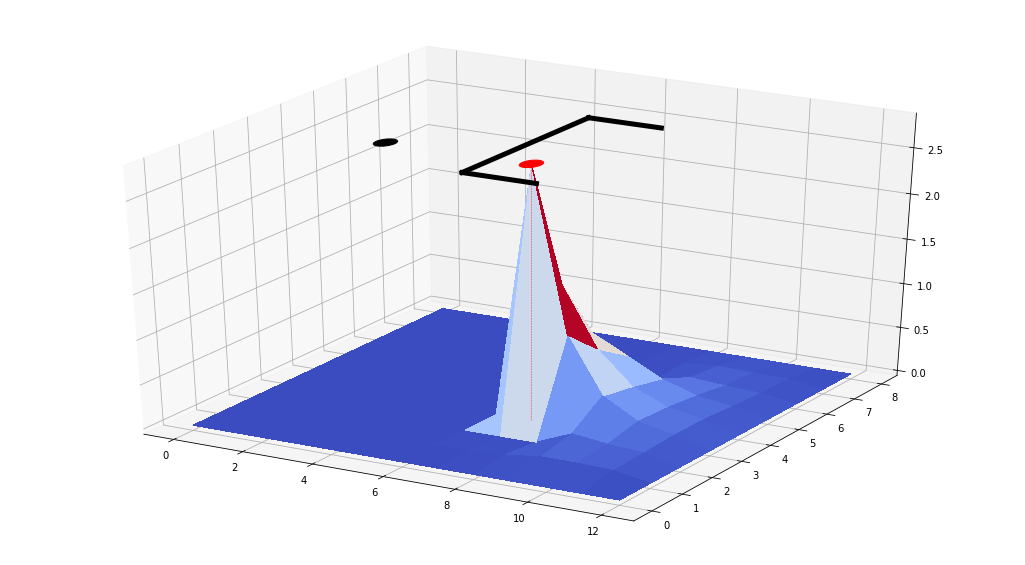

In [13]:
print('Learned Successor Representation at state (3,7):')
plt.rcParams['figure.figsize'] = [18, 10]
s = (3,7)
Z = predict_future_occupancy(s)

X = np.array([i for i in range(Z.shape[0])])
Y = np.array([i for i in range(Z.shape[1])])
X, Y = np.meshgrid(Y, X)

fig=plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z,cmap = cm.coolwarm, linewidth=0, antialiased=False)
line = ax.plot([s[1],s[1]],[s[0],s[0]],[0,Z.max()],'k--',alpha=0.8, linewidth=0.5, color='red')

h=1.0*Z.max()
line = ax.plot([6,8],[2,2],[h,h], alpha=1, linewidth=5, color='black')
line = ax.plot([6,8],[6,6],[h,h], alpha=1, linewidth=5, color='black')
line = ax.plot([6,6],[2,6],[h,h], alpha=1, linewidth=5, color='black')
p = Circle((3, 3), 0.25, color='black')
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=h, zdir="z")

p = Circle((s[1], s[0]), 0.25, color='red')
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=h, zdir="z")

plt.show()

In [14]:
Phi_approx = np.zeros((n_states,n_states))
for s in states:
    M = predict_future_occupancy(s)
    Phi_s = np.zeros(n_states)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            idx = state_to_index[(i,j)]
            Phi_s[idx] = M[i,j]
    Phi_approx[state_to_index[s]] = Phi_s

#### Correlation between successor representations at position (3,7)

In [15]:
np.corrcoef(Phi_approx[state_to_index[(3,7)]], Phi_exact[state_to_index[(3,7)]])

array([[1.        , 0.98707987],
       [0.98707987, 1.        ]])

### Learning Value Function with TD(0)

In [16]:
V_td = np.zeros(n_states)
alpha=0.1
n_episodes = 10000
elapsed_episodes = 0
while True:
    steps = 0
    if elapsed_episodes > n_episodes:
        break
    while True:
        steps +=1
        
        a,b = obs_to_state(obs)
        action = np.random.randint(4)
        
        obs, reward, gamma = game.play(action)
        a_,b_ = obs_to_state(obs)
        
        s = (a,b)
        s_ = (a_,b_)
        
        V_td[state_to_index[s]] += alpha*(reward + gamma*V_td[state_to_index[s_]] - V_td[state_to_index[s]])
        
        if gamma == 0: # Episode terminated
            elapsed_episodes += 1
            if elapsed_episodes%1000 == 0:
                print('episode # %s'%elapsed_episodes,25*'=', 'terminated in %s steps'%steps, 25*'=')
            game = grid_task.make_game()
            obs, reward, gamma = game.its_showtime()
            break

episode # 1000 ========================= terminated in 1899 steps =========================
episode # 2000 ========================= terminated in 316 steps =========================
episode # 3000 ========================= terminated in 378 steps =========================
episode # 4000 ========================= terminated in 59 steps =========================
episode # 5000 ========================= terminated in 513 steps =========================
episode # 6000 ========================= terminated in 423 steps =========================
episode # 7000 ========================= terminated in 836 steps =========================
episode # 8000 ========================= terminated in 135 steps =========================
episode # 9000 ========================= terminated in 542 steps =========================
episode # 10000 ========================= terminated in 356 steps =========================


### Using SR to Predict the Value Function: 
$$\LARGE v_{\pi}(s) = \phi_{\pi}(s)^Tr_{\pi}$$

In [17]:
V_sr = np.dot(Phi_approx.T, r)

#### Correlation between value functions obtained using TD(0) and SR.

In [18]:
print(np.corrcoef(V_sr, V_td))

[[1.         0.95945029]
 [0.95945029 1.        ]]


#### Plotting value functions obtained using TD(0) and SR.

SR-derived:


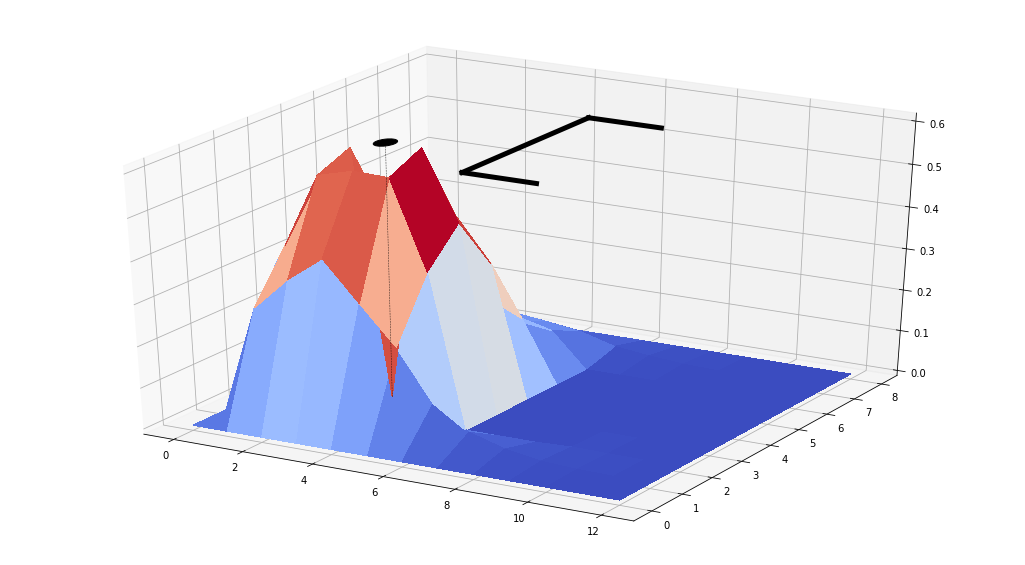

TD(0)-derived:


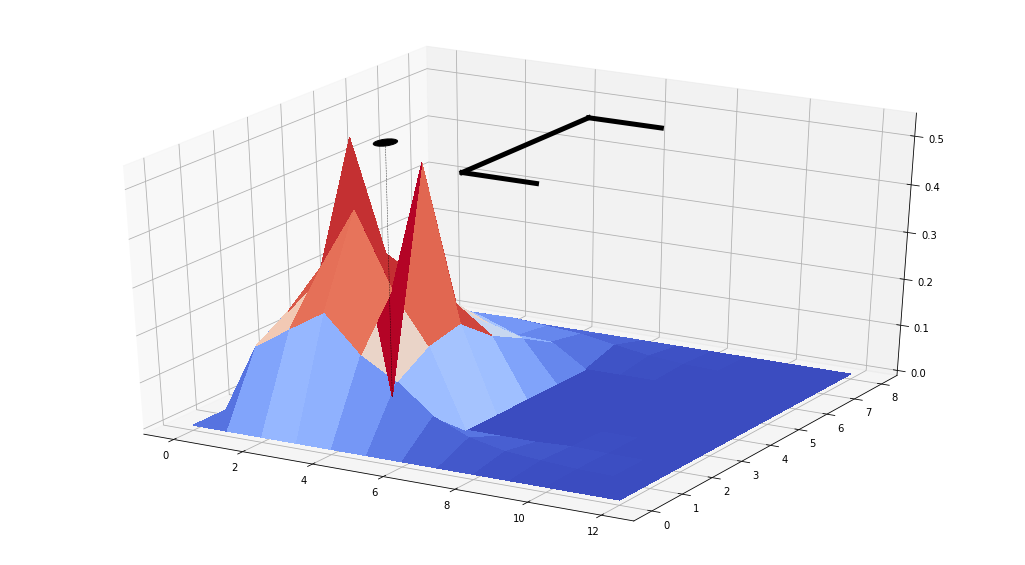

In [19]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 10]
for V,title in zip([V_sr, V_td],['SR-derived:','TD(0)-derived:']):
    print(title)
    Z = np.zeros((X_dim, Y_dim))
    for idx, z in enumerate(V):
        i,j = index_to_state[idx]
        Z[i,j] = z

    X = np.array([i for i in range(Z.shape[0])])
    Y = np.array([i for i in range(Z.shape[1])])
    X, Y = np.meshgrid(Y, X)

    fig=plt.figure()
    ax = fig.gca(projection='3d')

    surf = ax.plot_surface(X, Y, Z,cmap = cm.coolwarm, linewidth=0, antialiased=False)

    h=1.0*Z.max()
    line = ax.plot([6,8],[2,2],[h,h], alpha=1, linewidth=5, color='black')
    line = ax.plot([6,8],[6,6],[h,h], alpha=1, linewidth=5, color='black')
    line = ax.plot([6,6],[2,6],[h,h], alpha=1, linewidth=5, color='black')
    p = Circle((3, 3), 0.25, color='black')
    line = ax.plot([3,3],[3,3],[0,Z.max()],'k--',alpha=0.8, linewidth=0.5, color='black')
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=h, zdir="z")

    plt.show()